# Model building

In [ ]:
import pickle
from pathlib import Path

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import cross_val_score, HalvingGridSearchCV, train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV

%cd ..

import src.configuration as config

## 1. Load data

In [3]:
train_df=pd.read_csv(config.TRAINING_DATAFILE)
test_df=pd.read_csv(config.TESTING_DATAFILE)

In [4]:
train_df

,incident,time_sin,time_cos,route_encoded
0,0,-0.958820,0.284015,62
1,0,0.996566,-0.082808,240
2,0,-0.884988,-0.465615,154
3,0,0.370557,-0.928810,39
4,0,-0.760406,0.649448,561
...,...,...,...,...
484172,0,0.056693,-0.998392,219
484173,0,-0.979045,0.203642,119
484174,0,-0.559193,0.829038,20
484175,0,-0.992005,0.126199,134


In [11]:
train_df.head(5).T

,0,1,2,3,4
incident,0.000000,0.000000,0.000000,0.000000,0.000000
time_sin,-0.958820,0.996566,-0.884988,0.370557,-0.760406
time_cos,0.284015,-0.082808,-0.465615,-0.928810,0.649448
route_encoded,62.000000,240.000000,154.000000,39.000000,561.000000


In [12]:
test_df.head(5).T

,0,1,2,3,4
incident,1.000000,0.000000,0.000000,0.000000,0.000000
time_sin,0.766044,-0.998630,0.533615,0.258819,0.074108
time_cos,0.642788,0.052336,-0.845728,-0.965926,-0.997250
route_encoded,1.000000,93.000000,575.000000,249.000000,151.000000


## 2. Cross-validation: model

In [13]:
def cross_val_boosting_model(training_data: pd.DataFrame, testing_data: pd.DataFrame, target_variable: str, model):
    X_train = training_data.drop(columns=target_variable)
    y_train = training_data[target_variable]
    X_test = testing_data.drop(columns=target_variable)
    y_test = testing_data[target_variable]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(scores)
    return X_train, y_train, y_test, y_pred

hist_boost_model = HistGradientBoostingClassifier(random_state=42)
X_train, y_train, y_test, y_pred = cross_val_boosting_model(train_df, test_df, 'incident', hist_boost_model)

[0.99701557 0.99674708 0.99663345 0.99689162 0.99694325]


## 3. Test-set performance: confusion matrix

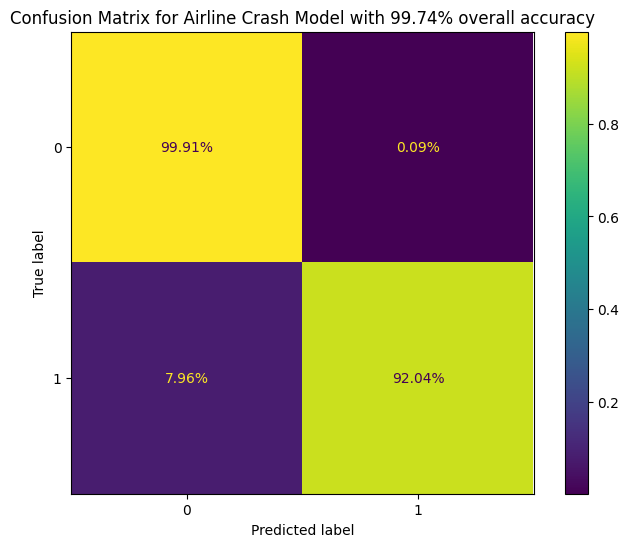

In [14]:
# Plot a confusion matrix to evaluate the model's performance on unseen data
def confusion_plot(y_test, y_pred, model):
    acc = accuracy_score(y_test, y_pred)*100
    conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)
    ax.set(title=f'Confusion Matrix for Airline Crash Model with {acc:.2f}% overall accuracy')
    display.plot(ax=ax, values_format='.2%');

confusion_plot(y_test, y_pred, hist_boost_model)

## 4. Model optimization

### Probability Calibration

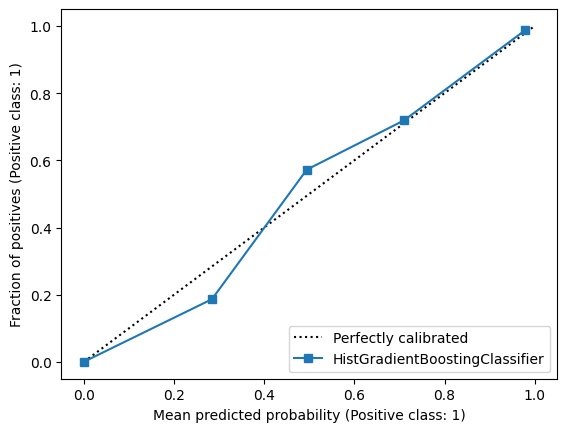

In [15]:
def calibration_plot(model, testing_data: pd.DataFrame, target_variable: str):
    X_test = testing_data.drop(columns=target_variable)
    y_test = testing_data[target_variable]
    disp = CalibrationDisplay.from_estimator(model, X_test, y_test)
    plt.show()

calibration_plot(hist_boost_model, test_df, 'incident')

In [16]:
def calibrate_probability(model, training_data: pd.DataFrame, target_variable: str):
    X_train = training_data.drop(columns=target_variable)
    y_train = training_data[target_variable]
    calibrated_hist_boost_model = CalibratedClassifierCV(model, cv=5)
    calibrated_hist_boost_model.fit(X_train, y_train)
    return calibrated_hist_boost_model

calibrated_hist_boost_model = calibrate_probability(hist_boost_model, train_df, 'incident')

In [17]:
def predict_calibrated_probabilities(testing_data: pd.DataFrame, target_variable: str):
    X_test = testing_data.drop(columns=target_variable)
    y_true = testing_data[target_variable]
    calibrated_probability = calibrated_hist_boost_model.predict_proba(X_test)
    return calibrated_probability

calibrated_probability = predict_calibrated_probabilities(test_df, 'incident')

In [18]:
positive_class_probability = calibrated_probability[:, 1]
positive_class_probability = positive_class_probability * 100
positive_class_probability

array([9.70806853e+01, 1.23707009e-01, 7.03276379e-02, ...,
       4.60375766e+00, 5.33240752e+00, 6.99303805e-02])

In [19]:

np.unique(positive_class_probability).size

11836

In [20]:
np.unique(positive_class_probability)

array([1.39532005e-02, 1.46142390e-02, 1.46361118e-02, ...,
       9.74637898e+01, 9.74775286e+01, 9.74890797e+01])

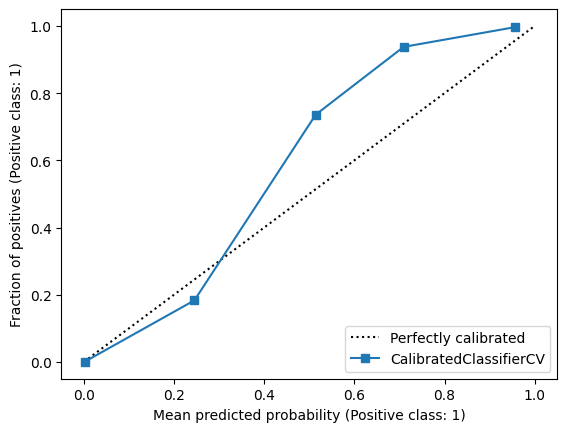

In [21]:
calibration_plot(calibrated_hist_boost_model, test_df, 'incident')

In [22]:
def get_predictions(training_data: pd.DataFrame, testing_data: pd.DataFrame, target_variable: str, model):
    X_train = training_data.drop(columns=target_variable)
    y_train = training_data[target_variable]
    X_test = testing_data.drop(columns=target_variable)
    y_test = testing_data[target_variable]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(y_pred) 
    return y_pred, y_test

y_pred, y_test = get_predictions(train_df, test_df, 'incident', calibrated_hist_boost_model)

[1 0 0 ... 0 0 0]


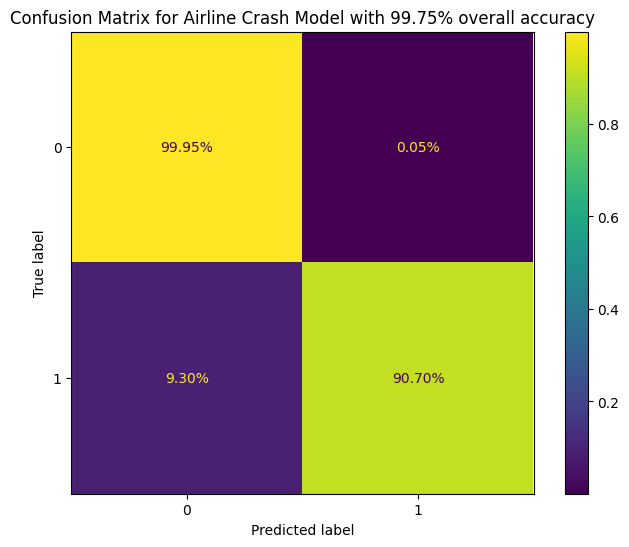

In [23]:
confusion_plot(y_test, y_pred, calibrated_hist_boost_model)

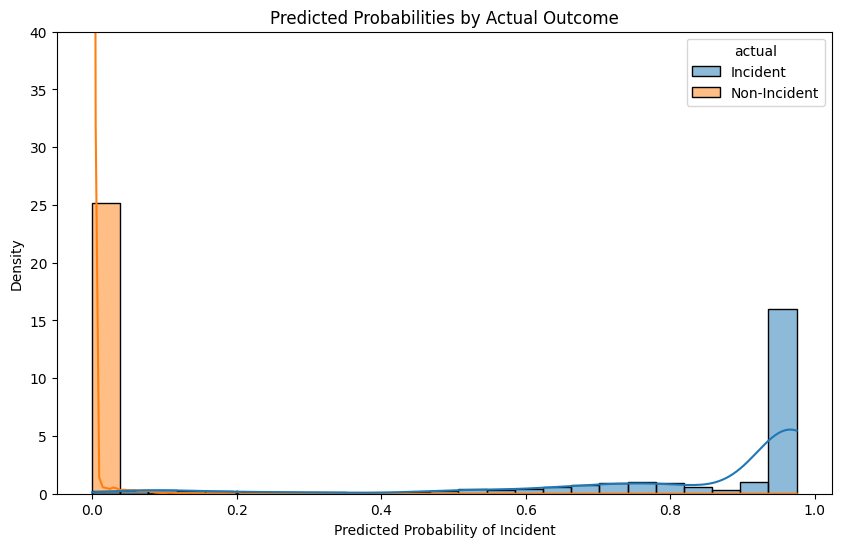

In [24]:
def probabilities_plot(model, testing_data):
    y_true = testing_data['incident']
    X_test = testing_data.drop(columns=['incident'])
    prob_incident = model.predict_proba(X_test)[:, 1]
    plot_df = pd.DataFrame({
        'probability': prob_incident,
        'actual': y_true.map({0: 'Non-Incident', 1: 'Incident'})
    })

    # Plot the distributions
    plt.figure(figsize=(10, 6))
    sns.histplot(data=plot_df, x='probability', hue='actual', bins=25, kde=True, stat='density', common_norm=False)
    plt.title('Predicted Probabilities by Actual Outcome')
    plt.xlabel('Predicted Probability of Incident')
    plt.ylabel('Density')
    plt.ylim(top=40)
    plt.show()

probabilities_plot(calibrated_hist_boost_model, test_df)

### Hyperparameter Tuning

In [25]:
# optimize the model
def get_best_params(model, optimizer):
    hyper_params = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'max_iter': [100, 200, 500, 1000],
        'max_leaf_nodes': [15, 31, 63, 127],
        'l2_regularization': [0.0, 0.1, 1.0, 10.0],
    }

    grid = optimizer(model, hyper_params, scoring='balanced_accuracy', cv=5, n_jobs=-1)
    return grid

grid = get_best_params(hist_boost_model, HalvingGridSearchCV)

In [26]:
run_grid = True

if run_grid:
    def warn(*args, **kwargs):
        pass
    import warnings
    warnings.warn = warn

    grid.fit(X_train, y_train)

    print(f"Best hyperparameters: {grid.best_params_}")

Best hyperparameters: {'l2_regularization': 0.0, 'learning_rate': 0.1, 'max_iter': 500, 'max_leaf_nodes': 127}


In [27]:
optimized_hist_boost_model = HistGradientBoostingClassifier(l2_regularization= 0.1, learning_rate= 0.01, max_iter= 1000, max_leaf_nodes= 15, random_state=42)

X_train, y_train, y_test, y_pred = cross_val_boosting_model(train_df, test_df, 'incident', optimized_hist_boost_model)

[0.99723243 0.99707753 0.99695358 0.99752156 0.99716012]


In [28]:
y_pred, y_test = get_predictions(train_df, test_df, 'incident', optimized_hist_boost_model)

[1 0 0 ... 0 0 0]


## 5. Test-set performance: confusion matrix

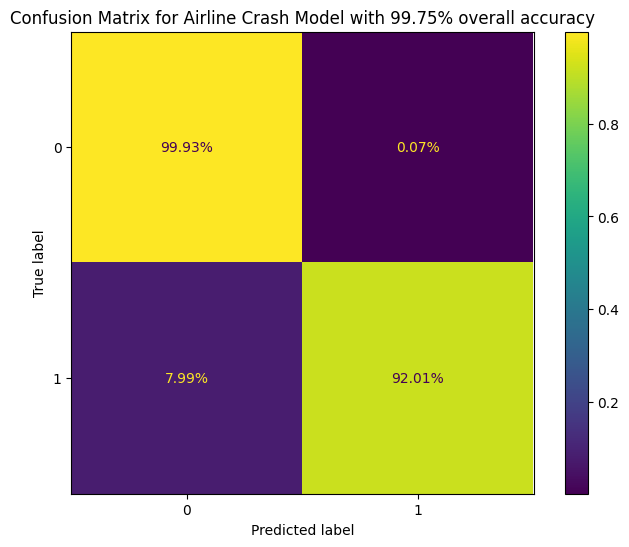

In [29]:
confusion_plot(y_test, y_pred, optimized_hist_boost_model)

## 6. Probability distributions

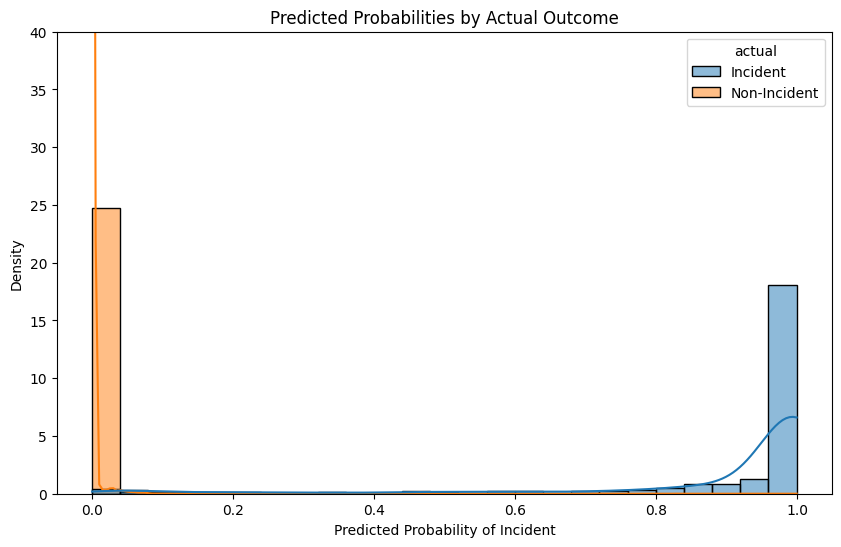

In [30]:
# Plot the distributions of predicted probabilities for 

probabilities_plot(optimized_hist_boost_model, test_df)

## 7. Save the best model

In [32]:
Path(config.MODEL_DIRECTORY).mkdir(parents=True, exist_ok=True)

with open(config.MODEL, 'wb') as output_file:
    pickle.dump(hist_boost_model, output_file)
    